## Ideas:
- overlapping context and query to emph identity

In [58]:
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy import sinc
import pytorch_lightning as pl
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from typing import Callable, Optional

In [2]:
def sinc_family(a: Optional[float] = 1.,
                b: Optional[float] = 1.,
                c: Optional[float] = 0.,
                d: Optional[float] = 0.
               ) -> Callable:
    return lambda x: a*sinc(b * x + c) + d

def get_random_sinc_function() -> Callable:
    a = 0.25 + 2 * random.random()
    b = random.random()
    c = 0
    d = 0
    return sinc_family(a, b, c, d)

In [3]:
def get_random_sinc_samples(
    num_samples: Optional[int] = 5,
    lower: Optional[float] = -10,
    upper: Optional[float] = 10,
    ):
    f = get_random_sinc_function()
    xs = torch.tensor([random.uniform(lower, upper) for _ in range(num_samples)])
    ys = torch.tensor(f(xs))
    
    return xs, ys, f
    
    

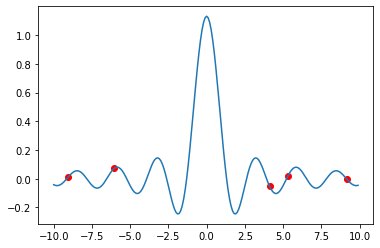

In [4]:
x_samples, y_samples, f = get_random_sinc_samples()

x = np.arange(-10, 10, .1)

plt.plot(x, f(x))
plt.scatter(x_samples, y_samples, c='r')
plt.show()

In [5]:
class SincDataset(Dataset):
    def __init__(self, len: int,
                 contexts: Optional[int] = 5,
                 queries: Optional[int] = 3,
                 lower: Optional[float] = -10,
                 upper: Optional[float] = 10,
                ):
        self.len = len
        self.lower = lower
        self.upper = upper
        self.contexts = contexts
        self.queries = queries
        
        self._sample()
        
    def _sample(self):
        self.samples = [get_random_sinc_samples(self.contexts + self.queries, self.lower, self.upper) for _ in range(self.len)]
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        xs, ys, f = self.samples[idx]

        context_x, context_y = xs[:self.contexts], ys[:self.contexts]
        queries_x, queries_y = xs[self.contexts:], ys[self.contexts:]
        
        return (context_x.unsqueeze(-1), context_y.unsqueeze(-1), queries_x.unsqueeze(-1)), queries_y.unsqueeze(-1)
        
        

In [6]:
ds_dummy = SincDataset(10_000, contexts=50, queries=10)

In [7]:
(context_x, context_y, queries_x), y = ds_dummy[random.randint(0, 10_000)]

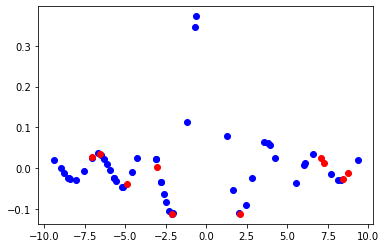

In [8]:
plt.scatter(context_x, context_y, c='b')
plt.scatter(queries_x, y, c='r')

In [121]:
ds_train = SincDataset(100_000, contexts=10, queries=20)
ds_valid = SincDataset(2_000, contexts=10, queries=20)

dl_train = DataLoader(ds_train, batch_size=64, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=64, shuffle=False)

//anaconda3/envs/dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [122]:
(context_x, context_y, queries_x), y = next(iter(dl_train))

In [123]:
context_x.shape, context_y.shape, queries_x.shape, y.shape

(torch.Size([64, 10, 1]),
 torch.Size([64, 10, 1]),
 torch.Size([64, 20, 1]),
 torch.Size([64, 20, 1]))

## Model

```
context x, context y, target x, target y
torch.Size([16, 217, 2]) torch.Size([16, 217, 1]) torch.Size([16, 732, 2]) torch.Size([16, 732, 1])
```

In [124]:
class Linear(nn.Module):
    """
    Linear Module
    """
    def __init__(self, in_dim, out_dim, bias=True, w_init='linear'):
        """
        :param in_dim: dimension of input
        :param out_dim: dimension of output
        :param bias: boolean. if True, bias is included.
        :param w_init: str. weight inits with xavier initialization.
        """
        super(Linear, self).__init__()
        self.linear_layer = nn.Linear(in_dim, out_dim, bias=bias)

        nn.init.xavier_uniform_(
            self.linear_layer.weight,
            gain=nn.init.calculate_gain(w_init))

    def forward(self, x):
        return self.linear_layer(x)

class LatentEncoder(nn.Module):
    """
    Latent Encoder [For prior, posterior]
    """
    def __init__(self, num_hidden, num_latent, input_dim=2):
        super(LatentEncoder, self).__init__()
        self.input_projection = Linear(input_dim, num_hidden)
        self.self_attentions = nn.ModuleList([Attention(num_hidden) for _ in range(2)])
        self.penultimate_layer = Linear(num_hidden, num_hidden, w_init='relu')
        self.mu = Linear(num_hidden, num_latent)
        self.log_sigma = Linear(num_hidden, num_latent)

    def forward(self, x, y):
        # concat location (x) and value (y)
        encoder_input = torch.cat([x,y], dim=-1)
        
        # project vector with dimension 3 --> num_hidden
        encoder_input = self.input_projection(encoder_input)
        
        # self attention layer
        for attention in self.self_attentions:
            encoder_input, _ = attention(encoder_input, encoder_input, encoder_input)
        
        # mean
        hidden = encoder_input.mean(dim=1)
        hidden = torch.relu(self.penultimate_layer(hidden))
        
        # get mu and sigma
        mu = self.mu(hidden)
        log_sigma = self.log_sigma(hidden)
        
        # reparameterization trick
        std = torch.exp(0.5 * log_sigma)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)
        
        # return distribution
        return mu, log_sigma, z
    
class DeterministicEncoder(nn.Module):
    """
    Deterministic Encoder [r]
    """
    def __init__(self, num_hidden, num_latent, input_dim=2):
        super(DeterministicEncoder, self).__init__()
        self.self_attentions = nn.ModuleList([Attention(num_hidden) for _ in range(2)])
        self.cross_attentions = nn.ModuleList([Attention(num_hidden) for _ in range(2)])
        self.input_projection = Linear(input_dim, num_hidden)
        self.context_projection = Linear(1, num_hidden)  # TK 2->1 line below as well
        self.target_projection = Linear(1, num_hidden)

    def forward(self, context_x, context_y, target_x):
        # concat context location (x), context value (y)
        encoder_input = torch.cat([context_x,context_y], dim=-1)
        
        # project vector with dimension 3 --> num_hidden
        encoder_input = self.input_projection(encoder_input)
        
        # self attention layer
        for attention in self.self_attentions:
            encoder_input, _ = attention(encoder_input, encoder_input, encoder_input)
        
        # query: target_x, key: context_x, value: representation
        query = self.target_projection(target_x)
        keys = self.context_projection(context_x)
        
        # cross attention layer
        for attention in self.cross_attentions:
            query, _ = attention(keys, encoder_input, query)
        
        return query
    
class Decoder(nn.Module):
    """
    Decoder for generation 
    """
    def __init__(self, num_hidden):
        super(Decoder, self).__init__()
        self.target_projection = Linear(1, num_hidden)  # TK 2->1
        self.linears = nn.ModuleList([Linear(num_hidden * 3, num_hidden * 3, w_init='relu') for _ in range(3)])
        self.final_projection = Linear(num_hidden * 3, 1)
        
    def forward(self, r, z, target_x):
        batch_size, num_targets, _ = target_x.size()
        # project vector with dimension 2 --> num_hidden
        target_x = self.target_projection(target_x)
        
        # concat all vectors (r,z,target_x)
        hidden = torch.cat([torch.cat([r,z], dim=-1), target_x], dim=-1)
        
        # mlp layers
        for linear in self.linears:
            hidden = torch.relu(linear(hidden))
            
        # get mu and sigma
        y_pred = self.final_projection(hidden)
        
        return y_pred

class MultiheadAttention(nn.Module):
    """
    Multihead attention mechanism (dot attention)
    """
    def __init__(self, num_hidden_k):
        """
        :param num_hidden_k: dimension of hidden 
        """
        super(MultiheadAttention, self).__init__()

        self.num_hidden_k = num_hidden_k
        self.attn_dropout = nn.Dropout(p=0.1)

    def forward(self, key, value, query):
        # Get attention score
        attn = torch.bmm(query, key.transpose(1, 2))
        attn = attn / math.sqrt(self.num_hidden_k)
        
        attn = torch.softmax(attn, dim=-1)

        # Dropout
        attn = self.attn_dropout(attn)
        
        # Get Context Vector
        result = torch.bmm(attn, value)

        return result, attn


class Attention(nn.Module):
    """
    Attention Network
    """
    def __init__(self, num_hidden, h=4):
        """
        :param num_hidden: dimension of hidden
        :param h: num of heads 
        """
        super(Attention, self).__init__()

        self.num_hidden = num_hidden
        self.num_hidden_per_attn = num_hidden // h
        self.h = h

        self.key = Linear(num_hidden, num_hidden, bias=False)
        self.value = Linear(num_hidden, num_hidden, bias=False)
        self.query = Linear(num_hidden, num_hidden, bias=False)

        self.multihead = MultiheadAttention(self.num_hidden_per_attn)

        self.residual_dropout = nn.Dropout(p=0.1)

        self.final_linear = Linear(num_hidden * 2, num_hidden)

        self.layer_norm = nn.LayerNorm(num_hidden)

    def forward(self, key, value, query):

        batch_size = key.size(0)
        seq_k = key.size(1)
        seq_q = query.size(1)
        residual = query
        
        # Make multihead
        key = self.key(key).view(batch_size, seq_k, self.h, self.num_hidden_per_attn)
        value = self.value(value).view(batch_size, seq_k, self.h, self.num_hidden_per_attn)
        query = self.query(query).view(batch_size, seq_q, self.h, self.num_hidden_per_attn)

        key = key.permute(2, 0, 1, 3).contiguous().view(-1, seq_k, self.num_hidden_per_attn)
        value = value.permute(2, 0, 1, 3).contiguous().view(-1, seq_k, self.num_hidden_per_attn)
        query = query.permute(2, 0, 1, 3).contiguous().view(-1, seq_q, self.num_hidden_per_attn)

        # Get context vector
        result, attns = self.multihead(key, value, query)

        # Concatenate all multihead context vector
        result = result.view(self.h, batch_size, seq_q, self.num_hidden_per_attn)
        result = result.permute(1, 2, 0, 3).contiguous().view(batch_size, seq_q, -1)
        
        # Concatenate context vector with input (most important)
        result = torch.cat([residual, result], dim=-1)
        
        # Final linear
        result = self.final_linear(result)

        # Residual dropout & connection
        result = self.residual_dropout(result)
        result = result + residual

        # Layer normalization
        result = self.layer_norm(result)

        return result, attns
    

In [125]:
class LatentModel(nn.Module):
    """
    Latent Model (Attentive Neural Process)
    """
    def __init__(self, num_hidden):
        super(LatentModel, self).__init__()
        self.latent_encoder = LatentEncoder(num_hidden, num_hidden)
        self.deterministic_encoder = DeterministicEncoder(num_hidden, num_hidden)
        self.decoder = Decoder(num_hidden)
        self.loss = nn.MSELoss()
        
    def forward(self, context_x, context_y, target_x, target_y=None):
        num_targets = target_x.size(1)
        
        prior_mu, prior_var, prior = self.latent_encoder(context_x, context_y)
        
        # For training
        if target_y is not None:
            posterior_mu, posterior_var, posterior = self.latent_encoder(target_x, target_y)
            z = posterior
        
        # For Generation
        else:
            z = prior
        
        z = z.unsqueeze(1).repeat(1,num_targets,1) # [B, T_target, H]
        r = self.deterministic_encoder(context_x, context_y, target_x) # [B, T_target, H]
        
        # mu should be the prediction of target y
        y_pred = self.decoder(r, z, target_x)
        
        # For Training
        if target_y is not None:
            # get log probability
            loss = self.loss(y_pred, target_y)
            
            # get KL divergence between prior and posterior
            kl = self.kl_div(prior_mu, prior_var, posterior_mu, posterior_var)
            
            # maximize prob and minimize KL divergence
            #loss = loss + kl
        
        # For Generation
        else:
            log_p = None
            kl = None
            loss = None
        
        return y_pred, kl, loss
    
    def kl_div(self, prior_mu, prior_var, posterior_mu, posterior_var):
        kl_div = (torch.exp(posterior_var) + (posterior_mu-prior_mu) ** 2) / torch.exp(prior_var) - 1. + (prior_var - posterior_var)
        kl_div = 0.5 * kl_div.sum()
        return kl_div

In [126]:
model = LatentModel(128)
model = model.train()

In [127]:
y_pred, kl, loss = model(context_x, context_y, queries_x, y)

In [128]:
y_pred.shape

torch.Size([64, 20, 1])

In [129]:
class Model(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = LatentModel(128)
        #self.accuracy = pl.metrics.Accuracy()
    
    def forward(self, context_x, context_y, queries_x, y=None):

        # in lightning, forward defines the prediction/inference actions
        return self.model(context_x, context_y, queries_x, y)

    def training_step(self, batch, batch_idx):

        (context_x, context_y, queries_x), y = batch
        y_pred, kl, loss = self.forward(context_x, context_y, queries_x, y)
        
        #self.accuracy(preds[:,0,0], y)
        self.log('train_loss', loss)

        return loss
    
    def validation_step(self, batch, batch_idx):
        (context_x, context_y, queries_x), y = batch
        y_pred, kl, loss = self.forward(context_x, context_y, queries_x, y)

        self.log('valid_loss', loss)

        return loss
    
    def training_epoch_end(self, outs):
        # log epoch metric
        pass #self.log('train_acc_epoch', self.accuracy.compute())
        
    def validation_epoch_end(self, outs):
        # log epoch metric
        pass #self.log('valid_acc_epoch', self.accuracy.compute())


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)  # TK

        return optimizer

In [ ]:
pl_model = Model()
trainer = pl.Trainer(max_epochs=15, gpus=0) #, logger=mlf_logger)
trainer.fit(pl_model, dl_train, dl_valid)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type        | Params
--------------------------------------
0 | model | LatentModel | 988 K 
--------------------------------------
988 K     Trainable params
0         Non-trainable params
988 K     Total params


Epoch 0:   0%|          | 0/1595 [00:00<?, ?it/s] 

//anaconda3/envs/dev/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
//anaconda3/envs/dev/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  14%|█▍        | 225/1595 [00:21<02:12, 10.32it/s, loss=0.127, v_num=2]

//anaconda3/envs/dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


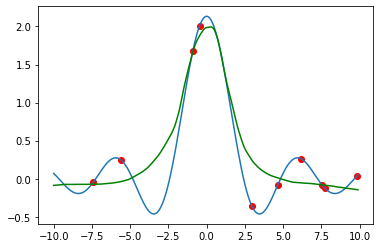

In [120]:
pl_model.model = pl_model.model.eval()

num_contexts = 10
x_samples, y_samples, f = get_random_sinc_samples(num_samples=num_contexts)

context_x, context_y = x_samples.unsqueeze(-1).unsqueeze(0), y_samples.unsqueeze(-1).unsqueeze(0)
queries_x = torch.arange(-10, 10, .1).unsqueeze(-1).unsqueeze(0)

with torch.no_grad():
    y_pred, kl, loss = pl_model(context_x, context_y, queries_x, None)

x = np.arange(-10, 10, .1)

plt.plot(x, f(x))
plt.scatter(context_x, context_y, c='r')
plt.plot(queries_x[0,:,0], y_pred[0,:,0], c='g')
plt.show()